<a href="https://colab.research.google.com/github/MangoDingo33/Advanced_AI/blob/main/03/0922_HAR_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the libraries

Load required libraries for modeling and data processing

In [62]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional, GRU
from keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

## Load data from google drive

Libraries to load data from google drive shared location.

In [63]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the python document (PyDrive) client.

In [64]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [65]:

dataset_file_id = '1xnD6OXIMNOChR4V9DKO-Jjsb7QNMUjc0'


Download the dataset file.

In [66]:
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('UCI HAR Dataset.zip')

Unzip the data to the same directory

In [67]:
!unzip "/content/UCI HAR Dataset.zip" -d "/content/"

Archive:  /content/UCI HAR Dataset.zip
replace /content/UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Helper functions to load and split train and test data

In [68]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples.

In [69]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [70]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


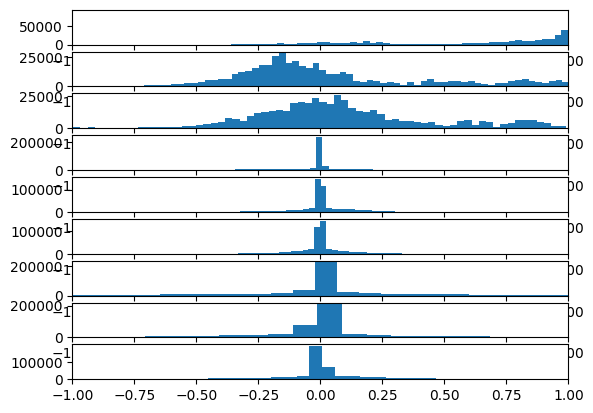

In [71]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions.

## Building the models

In this workshop, we will develop 2 deep learning models and evaluate the classification accuracy.



1.   LSTM model
2.   CNN model



Set common parameters across all the models

In [72]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

### BiLSTM model

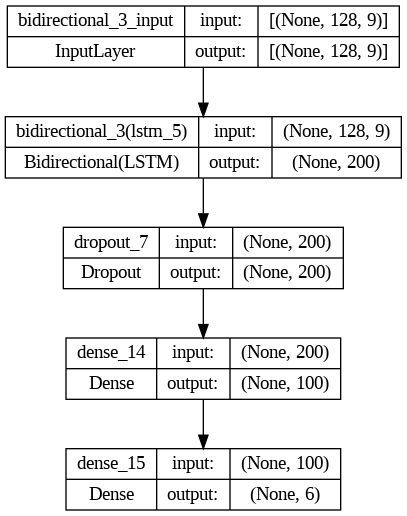

In [73]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(100), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)


Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [74]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [ ]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
56/92 [=================>............] - ETA: 10s - loss: 1.2784 - accuracy: 0.4587

Visualize the training process (loss) w.r.t train set and the validation set

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

In [ ]:
predictions

helper function to display results

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

### GRU model

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(GRU(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [56]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 32s 311ms/step - loss: 1.2605 - accuracy: 0.4696 - val_loss: 1.1209 - val_accuracy: 0.5207
Epoch 2/10
92/92 [==============================] - 27s 288ms/step - loss: 0.9482 - accuracy: 0.5929 - val_loss: 0.8688 - val_accuracy: 0.6621
Epoch 3/10
92/92 [==============================] - 19s 205ms/step - loss: 0.6781 - accuracy: 0.7235 - val_loss: 0.5429 - val_accuracy: 0.8056
Epoch 4/10
92/92 [==============================] - 19s 206ms/step - loss: 0.4321 - accuracy: 0.8308 - val_loss: 0.3853 - val_accuracy: 0.8722
Epoch 5/10
92/92 [==============================] - 31s 338ms/step - loss: 0.2710 - accuracy: 0.9066 - val_loss: 0.3298 - val_accuracy: 0.8953
Epoch 6/10
92/92 [==============================] - 28s 309ms/step - loss: 0.1867 - accuracy: 0.9316 - val_loss: 0.3421 - val_accuracy: 0.8987
Epoch 7/10
92/92 [==============================] - 17s 183ms/step - loss: 0.1873 - accuracy: 0.9296 - val_loss: 0.4032 - val_accuracy: 0.8756

Visualize the training process (loss) w.r.t train set and the validation set

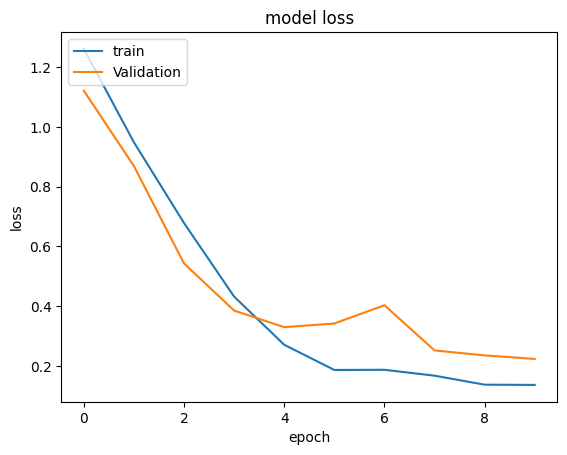

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [58]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the GRU model 0.8554462194442749
93/93 [==============================] - 4s 40ms/step


In [59]:
predictions

array([[2.3448204e-03, 1.5933065e-05, 3.1374202e-05, 1.0375980e-02,
        9.8723179e-01, 4.7386614e-08],
       [6.2754587e-04, 7.7559434e-06, 1.1221032e-05, 1.3484728e-02,
        9.8586875e-01, 3.7459358e-08],
       [5.8191986e-04, 7.2558009e-06, 1.0176169e-05, 1.3242472e-02,
        9.8615825e-01, 3.5281140e-08],
       ...,
       [1.4406847e-03, 9.9853432e-01, 2.5032276e-05, 7.3458330e-11,
        2.2800112e-08, 1.1266998e-12],
       [5.3238147e-04, 9.9946183e-01, 5.8279602e-06, 1.5655900e-11,
        8.3010132e-09, 2.0389274e-13],
       [9.5075718e-04, 9.9904400e-01, 5.1833840e-06, 4.0433171e-11,
        2.5147115e-08, 4.4391774e-13]], dtype=float32)

helper function to display results

In [60]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[444   5  38   0   9   0]
 [ 92 335  44   0   0   0]
 [  6   0 414   0   0   0]
 [  0   2   5 376 108   0]
 [  6   0   0  85 441   0]
 [  0  25   1   0   0 511]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.81      0.90      0.85       496
           2       0.91      0.71      0.80       471
           3       0.82      0.99      0.90       420
           4       0.82      0.77      0.79       491
           5       0.79      0.83      0.81       532
           6       1.00      0.95      0.98       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.85      2947
weighted avg       0.86      0.86      0.85      2947



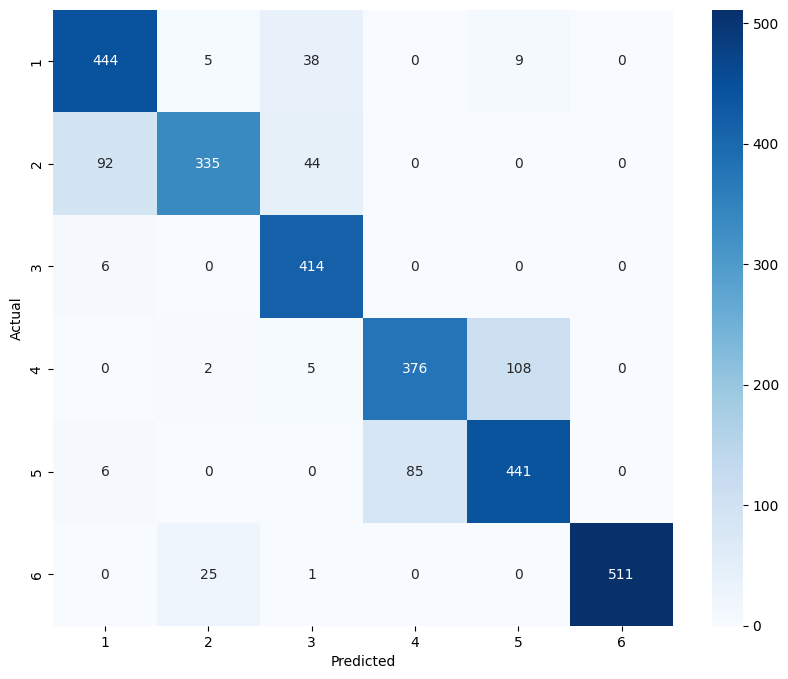

In [61]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

### BiGRU model

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(GRU(100), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)


Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [ ]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Visualize the training process (loss) w.r.t train set and the validation set

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiGRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

In [ ]:
predictions

helper function to display results

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)